HOG Feature shape: (0,)
Labels shape: (0,)


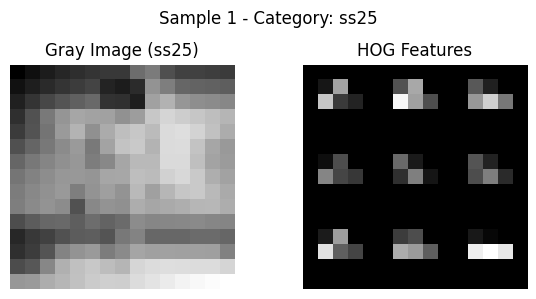

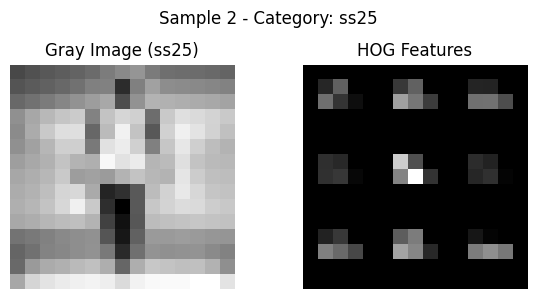

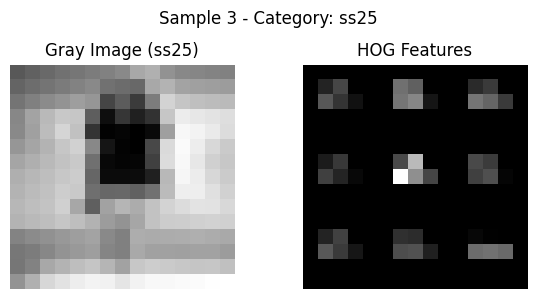

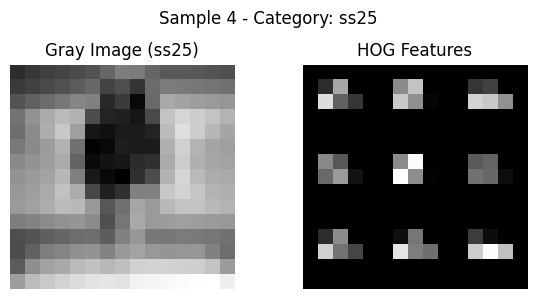

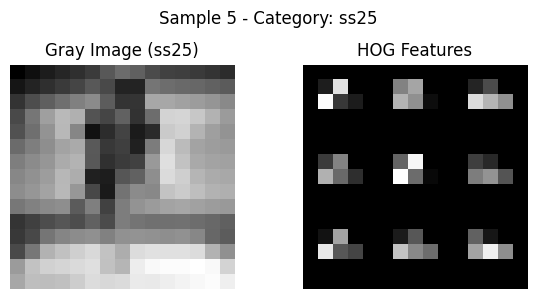

Train shape: (232, 81)
Test shape: (38, 81)
100.0% of test samples were correctly classified using HOG + SVM


In [6]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt


# define groups

train_categories = ['ss25','ss24','ss23','ss22','ss21','ss20','ss19']

#test_categories = ['ss25']

test_categories = ['ss25','ss24','ss23','ss22','ss21','ss20','ss19']

#test_categories = ['fw25','r25','fw24','r24','fw23','fw22','r22','fw21','r20','fw20','fw19','r19']

#test_categories = ['ss25','ss24','ss23','ss22','ss21','ss20','ss19']

# create  label map
all_categories = sorted(set(train_categories + test_categories))
label_map = {cat: idx for idx, cat in enumerate(all_categories)}

# prepare data
folder = 'images' 
image_extensions = ('.jpg') 

data = []
labels = []

# visualization
visualize_limit = 5  # show HOG for first 5 images
visualized = 0
def load_data(categories, label_map, folder='images', visualize=False, visualize_limit=5):
    data = []
    labels = []
    visualized = 0
    image_extensions = ('.jpg')

    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category folder '{category_path}' not found. Skipping.")
            continue

        for file in os.listdir(category_path):
            if not file.lower().endswith(image_extensions):
                continue

            img_path = os.path.join(category_path, file)
            try:
                img = imread(img_path)
                img = resize(img, (15, 15), anti_aliasing=True)
                gray = rgb2gray(img)
                hog_features, hog_image = hog(
                    gray,
                    pixels_per_cell=(5, 5),
                    cells_per_block=(1, 1),
                    visualize=True,
                    feature_vector=True
                )
                data.append(hog_features)
                labels.append(label_map[category])

                if visualize and visualized < visualize_limit:
                    plt.figure(figsize=(6, 3))
                    plt.subplot(1, 2, 1)
                    plt.imshow(gray, cmap='gray')
                    plt.title(f'Gray Image ({category})')
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(hog_image, cmap='gray')
                    plt.title('HOG Features')
                    plt.axis('off')

                    plt.suptitle(f'Sample {visualized + 1} - Category: {category}')
                    plt.tight_layout()
                    plt.show()
                    visualized += 1

            except Exception as e:
                print(f"Error reading image {img_path}: {e}")

    return np.asarray(data), np.asarray(labels)

data = np.asarray(data)
labels = np.asarray(labels)

print("HOG Feature shape:", data.shape)
print("Labels shape:", labels.shape)

# load training and testing sets 
x_train, y_train = load_data(train_categories, label_map, visualize=True)
x_test, y_test = load_data(test_categories, label_map, visualize=False)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

# train classifier
classifier = SVC()
parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = GridSearchCV(classifier, parameters)
grid_search.fit(x_train, y_train)

# evaluate
best_estimator = grid_search.best_estimator_
y_prediction = best_estimator.predict(x_test)

score = accuracy_score(y_prediction, y_test)
print('{}% of test samples were correctly classified using HOG + SVM'.format(str(score * 100)))

# save model
pickle.dump(best_estimator, open('./imgclass_hog', 'wb'))
